In [7]:
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
from  torch.utils.data import Dataset

## First, add this file to your drive [File](https://drive.google.com/drive/folders/1T1ox5SBkEf5QDn1w07f2w2teXbpPOjQX?usp=sharing)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Then mount your drive using colab's icon in the files section to the left


In [3]:
features= np.load('/content/drive/MyDrive/NMA_DL_project/feature_0.npy')
labels= np.load('/content/drive/MyDrive/NMA_DL_project/all_the_labels.npy')

Making sure that the data has the correct length

In [4]:
assert len(features)==len(labels)

In [5]:
features.shape

(2970, 128, 108)

In [6]:
features=features.reshape(2970,1,128,108)
features.shape

(2970, 1, 128, 108)

In [8]:

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y
        
    def __len__(self):
        return self.tensors[0].size(0)    

In [9]:
from  sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset, TensorDataset
x_train , x_test , y_train , y_test = train_test_split( features , labels , train_size=0.8, stratify=labels )

transform =transforms.GaussianBlur(3 , (0.001,0.4))
# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=16)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=16)

In [10]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()
device = set_device()

GPU is enabled in this notebook.


In [11]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 16 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=32),
            nn.Dropout(0.4),
            nn.Linear(in_features=32, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

In [12]:
def train(model, device, train_loader, validation_loader, epochs , optimizer):
  criterion =  nn.CrossEntropyLoss()
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device, dtype=torch.float ), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)
      print(f'The Train accuracy= {train_acc[epoch]} \n The Validation acc {validation_acc[epoch]}') 
      print(f'The Train loss= {train_loss[epoch]} \n The Validation loss {validation_loss[epoch]}')  
      print('\n')
  return train_loss, train_acc, validation_loss, validation_acc

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The Train accuracy= 0.281986531986532 
 The Validation acc 0.4595959595959596
The Train loss= 2.0261781215667725 
 The Validation loss 1.6554544034757113


The Train accuracy= 0.5 
 The Validation acc 0.5505050505050505
The Train loss= 1.4723459482192993 
 The Validation loss 1.4556813334163867


The Train accuracy= 0.6052188552188552 
 The Validation acc 0.5791245791245792
The Train loss= 1.2107285261154175 
 The Validation loss 1.3258560550840277


The Train accuracy= 0.6877104377104377 
 The Validation acc 0.5505050505050505
The Train loss= 0.97397381067276 
 The Validation loss 1.2955991170908276


The Train accuracy= 0.7638888888888888 
 The Validation acc 0.5909090909090909
The Train loss= 0.7890436053276062 
 The Validation loss 1.2238398413909108


The Train accuracy= 0.8324915824915825 
 The Validation acc 0.5993265993265994
The Train loss= 0.616141676902771 
 The Validation loss 1.1791023408111774


The Train accuracy= 0.8636363636363636 
 The Validation acc 0.606060606060606

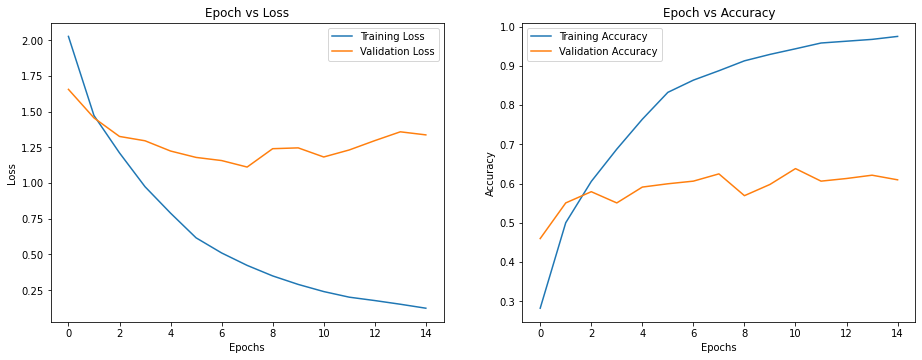

In [13]:
net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader,test_loader, 15, optimizer )
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [14]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.09301346801346802 
 The Validation acc 0.10101010101010101
The Train loss= 2.3297886848449707 
 The Validation loss 2.292695534856696


The Train accuracy= 0.09553872053872053 
 The Validation acc 0.09764309764309764
The Train loss= 2.3292739391326904 
 The Validation loss 2.292443137419851


The Train accuracy= 0.11069023569023569 
 The Validation acc 0.09595959595959595
The Train loss= 2.317734956741333 
 The Validation loss 2.2929126086987948


The Train accuracy= 0.10900673400673401 
 The Validation acc 0.09932659932659933
The Train loss= 2.3201732635498047 
 The Validation loss 2.291720616190057


The Train accuracy= 0.09806397306397306 
 The Validation acc 0.09932659932659933
The Train loss= 2.33455491065979 
 The Validation loss 2.291435618149607


The Train accuracy= 0.09974747474747475 
 The Validation acc 0.10101010101010101
The Train loss= 2.321079969406128 
 The Validation loss 2.2912652618006657


The Train accuracy= 0.10143097643097643 
 The Validati

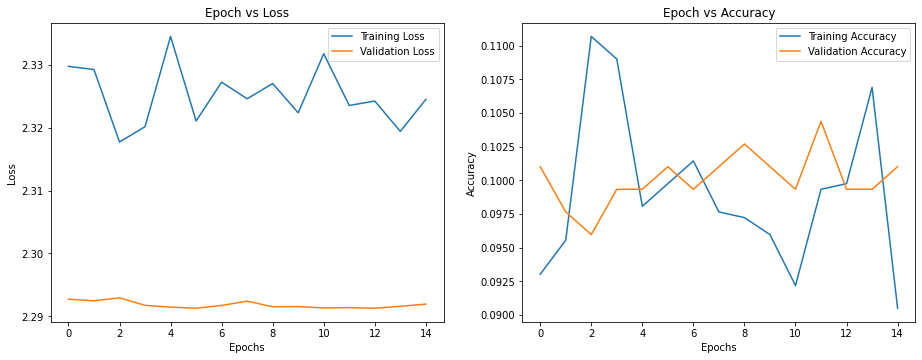

In [15]:
net = music_CNN().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader,test_loader, 15, optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [16]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.23484848484848486 
 The Validation acc 0.3686868686868687
The Train loss= 2.0648741722106934 
 The Validation loss 1.8586358898564388


The Train accuracy= 0.39351851851851855 
 The Validation acc 0.4562289562289562
The Train loss= 1.6989177465438843 
 The Validation loss 1.6675188227703697


The Train accuracy= 0.4730639730639731 
 The Validation acc 0.5
The Train loss= 1.5306479930877686 
 The Validation loss 1.5587889018811678


The Train accuracy= 0.5281986531986532 
 The Validation acc 0.5437710437710438
The Train loss= 1.3995784521102905 
 The Validation loss 1.4641323967983848


The Train accuracy= 0.5829124579124579 
 The Validation acc 0.5841750841750841
The Train loss= 1.281348466873169 
 The Validation loss 1.3864857068187313


The Train accuracy= 0.6115319865319865 
 The Validation acc 0.6111111111111112
The Train loss= 1.1901168823242188 
 The Validation loss 1.3324528383581262


The Train accuracy= 0.6603535353535354 
 The Validation acc 0.6127946127

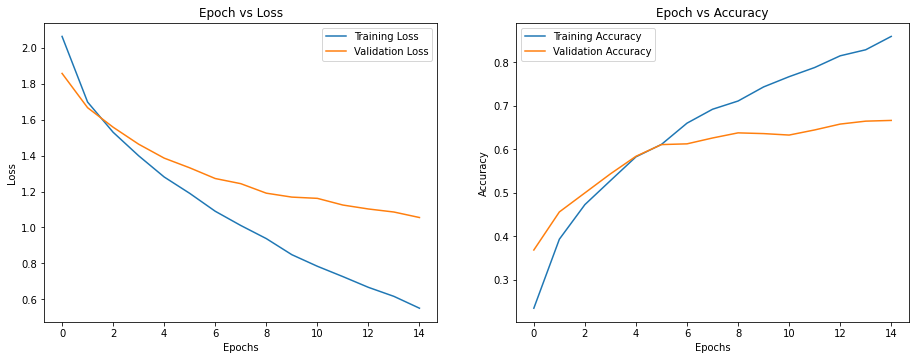

In [17]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.9)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [18]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 256 ) ,
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features=num_features_before_fcnn, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.35984848484848486 
 The Validation acc 0.4276094276094276
The Train loss= 1.9748811721801758 
 The Validation loss 1.8188852667808533


The Train accuracy= 0.5980639730639731 
 The Validation acc 0.51010101010101
The Train loss= 1.18822181224823 
 The Validation loss 1.604690830958517


The Train accuracy= 0.7335858585858586 
 The Validation acc 0.5808080808080808
The Train loss= 0.7970019578933716 
 The Validation loss 1.2435082981460972


The Train accuracy= 0.819023569023569 
 The Validation acc 0.6515151515151515
The Train loss= 0.5698331594467163 
 The Validation loss 1.0836537221544666


The Train accuracy= 0.8800505050505051 
 The Validation acc 0.6245791245791246
The Train loss= 0.37033742666244507 
 The Validation loss 1.1430281871243526


The Train accuracy= 0.928030303030303 
 The Validation acc 0.664983164983165
The Train loss= 0.2471744418144226 
 The Validation loss 1.0876349798942868


The Train accuracy= 0.9654882154882155 
 The Validation acc 0.70

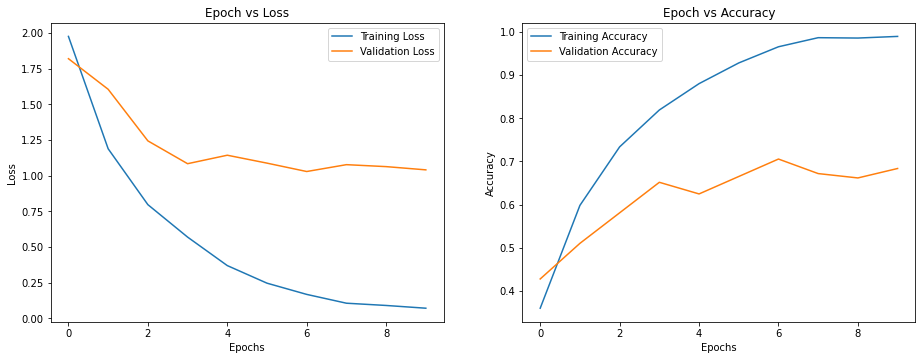

In [19]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.9)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 10 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# changing the data

In [20]:
from  sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset, TensorDataset
x_train , x_test , y_train , y_test = train_test_split( features , labels , train_size=0.6, stratify=labels )

transform =transforms.GaussianBlur(3 , (0.001,0.5))
# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.2996632996632997 
 The Validation acc 0.4823232323232323
The Train loss= 2.086531639099121 
 The Validation loss 1.5081953763961793


The Train accuracy= 0.5594837261503928 
 The Validation acc 0.5723905723905723
The Train loss= 1.2700635194778442 
 The Validation loss 1.3112574473023415


The Train accuracy= 0.7283950617283951 
 The Validation acc 0.6001683501683501
The Train loss= 0.8357770442962646 
 The Validation loss 1.2197443306446076


The Train accuracy= 0.8490460157126823 
 The Validation acc 0.6212121212121212
The Train loss= 0.5483039021492004 
 The Validation loss 1.1839221462607383


The Train accuracy= 0.8916947250280584 
 The Validation acc 0.6111111111111112
The Train loss= 0.4002135097980499 
 The Validation loss 1.1903952166438103


The Train accuracy= 0.9545454545454546 
 The Validation acc 0.569023569023569
The Train loss= 0.256680428981781 
 The Validation loss 1.2932756215333938


The Train accuracy= 0.9657687991021324 
 The Validation acc 0

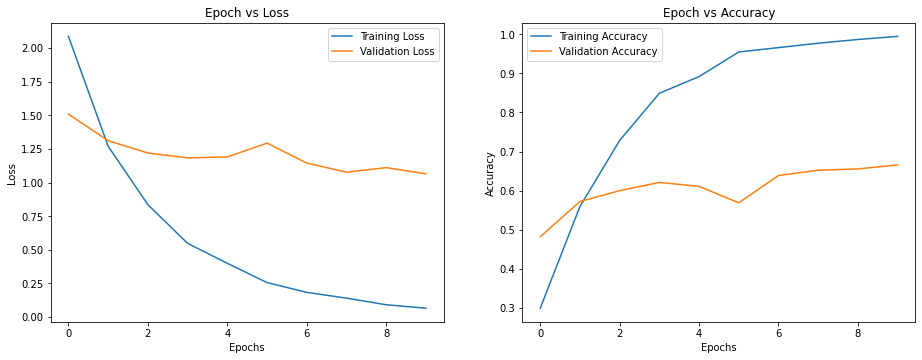

In [21]:
net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001 )
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 10 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [22]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 256 ) ,
            nn.MaxPool2d(kernel_size=2),
        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=128),
            nn.Dropout(0.4),
            nn.Linear(in_features=128, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.3569023569023569 
 The Validation acc 0.5176767676767676
The Train loss= 1.9074524641036987 
 The Validation loss 1.3693733766674996


The Train accuracy= 0.5937149270482603 
 The Validation acc 0.5656565656565656
The Train loss= 1.141542673110962 
 The Validation loss 1.2490810796618461


The Train accuracy= 0.7760942760942761 
 The Validation acc 0.601010101010101
The Train loss= 0.7025681734085083 
 The Validation loss 1.1691472306847572


The Train accuracy= 0.8765432098765432 
 The Validation acc 0.5429292929292929
The Train loss= 0.43718311190605164 
 The Validation loss 1.3448773324489594


The Train accuracy= 0.9567901234567902 
 The Validation acc 0.6119528619528619
The Train loss= 0.2239329069852829 
 The Validation loss 1.1241237804293633


The Train accuracy= 0.978675645342312 
 The Validation acc 0.6372053872053872
The Train loss= 0.14677907526493073 
 The Validation loss 1.1594218768179416


The Train accuracy= 0.9848484848484849 
 The Validation acc

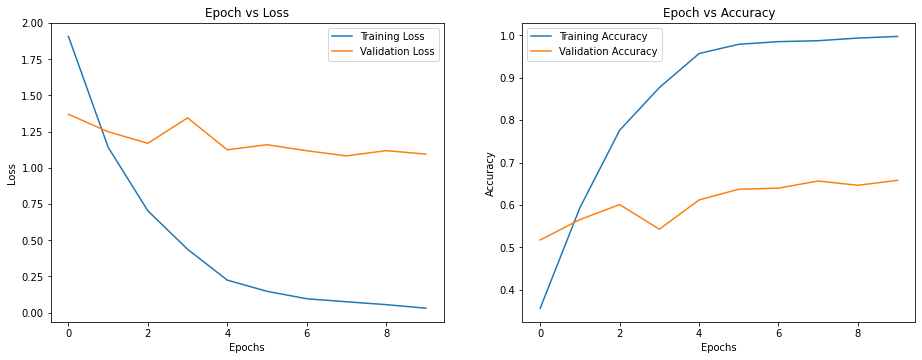

In [23]:
net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001 )
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 10 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [24]:

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),  
            )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=128),
            nn.Dropout(0.4),
            nn.Linear(in_features=128, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

The Train accuracy= 0.3507295173961841 
 The Validation acc 0.4890572390572391
The Train loss= 2.1678078174591064 
 The Validation loss 1.4955856204032898


The Train accuracy= 0.6066217732884399 
 The Validation acc 0.5202020202020202
The Train loss= 1.1647534370422363 
 The Validation loss 1.5570150315761566


The Train accuracy= 0.7934904601571269 
 The Validation acc 0.5892255892255892
The Train loss= 0.612298846244812 
 The Validation loss 1.3346090614795685


The Train accuracy= 0.8995510662177328 
 The Validation acc 0.601010101010101
The Train loss= 0.34046366810798645 
 The Validation loss 1.3463824167847633


The Train accuracy= 0.9287317620650954 
 The Validation acc 0.5648148148148148
The Train loss= 0.24015745520591736 
 The Validation loss 1.5567393437027932


The Train accuracy= 0.9696969696969697 
 The Validation acc 0.5563973063973064
The Train loss= 0.14008574187755585 
 The Validation loss 1.5806781321763992


The Train accuracy= 0.9842873176206509 
 The Validation a

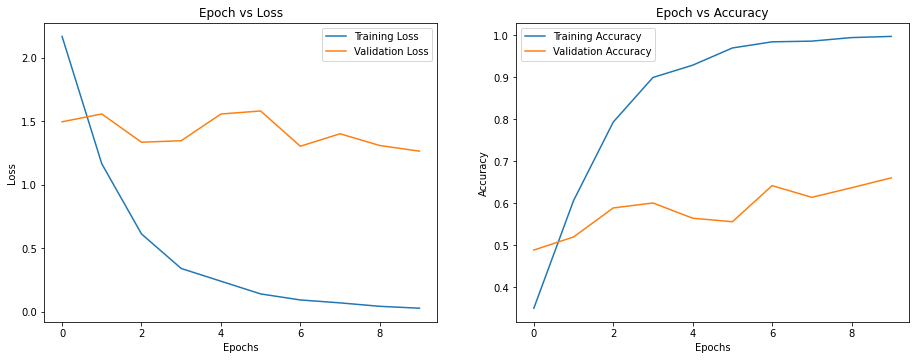

In [25]:
net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001 )
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 10 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# compining different features

In [26]:
first_feat= np.load('/content/drive/MyDrive/NMA_DL_project/feature_0.npy')
sec_feat= np.load('/content/drive/MyDrive/NMA_DL_project/feature_1.npy')
third_feat=np.load('/content/drive/MyDrive/NMA_DL_project/feature_2.npy')
forth_feat= np.load('/content/drive/MyDrive/NMA_DL_project/feature_3.npy')

In [27]:
first_and_sec= np.concatenate( (first_feat , sec_feat), axis=1) 

In [28]:
first_and_sec.shape

(2970, 129, 108)

In [29]:
first_and_sec= np.concatenate( (first_feat , sec_feat), axis=1).reshape(2970,1,129,108)

x_train , x_test , y_train , y_test = train_test_split( first_and_sec , labels , train_size=0.7, stratify=labels )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.2053872053872054 
 The Validation acc 0.3176206509539843
The Train loss= 2.181610584259033 
 The Validation loss 2.014238484700521


The Train accuracy= 0.3318903318903319 
 The Validation acc 0.3501683501683502
The Train loss= 1.9042363166809082 
 The Validation loss 1.7980967124303182


The Train accuracy= 0.3862433862433862 
 The Validation acc 0.3894500561167228
The Train loss= 1.7363694906234741 
 The Validation loss 1.6884040395418802


The Train accuracy= 0.4098124098124098 
 The Validation acc 0.42536475869809204
The Train loss= 1.6448460817337036 
 The Validation loss 1.6190239588419597


The Train accuracy= 0.45021645021645024 
 The Validation acc 0.4478114478114478
The Train loss= 1.573786973953247 
 The Validation loss 1.5627777616182963


The Train accuracy= 0.4843674843674844 
 The Validation acc 0.4601571268237935
The Train loss= 1.5042184591293335 
 The Validation loss 1.528185002009074


The Train accuracy= 0.49975949975949974 
 The Validation acc

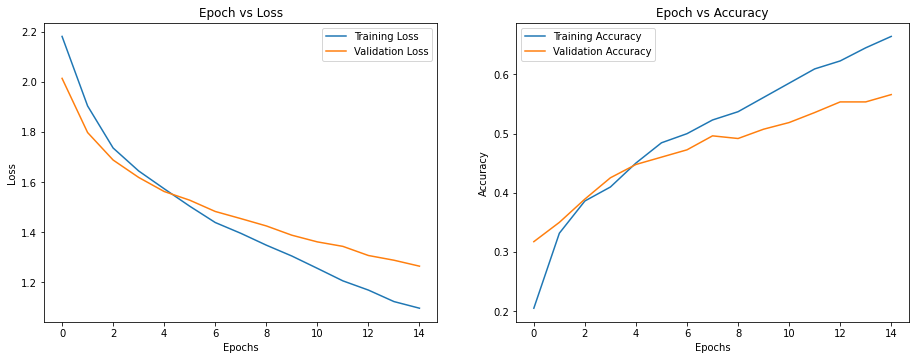

In [30]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.9)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

The Train accuracy= 0.32227032227032226 
 The Validation acc 0.4612794612794613
The Train loss= 1.8894697427749634 
 The Validation loss 1.5660778403282165


The Train accuracy= 0.5204425204425205 
 The Validation acc 0.5465768799102132
The Train loss= 1.3583227396011353 
 The Validation loss 1.3126860539118448


The Train accuracy= 0.6493506493506493 
 The Validation acc 0.5824915824915825
The Train loss= 1.033068060874939 
 The Validation loss 1.1701111396153767


The Train accuracy= 0.7407407407407407 
 The Validation acc 0.6374859708193041
The Train loss= 0.7898181676864624 
 The Validation loss 1.059377247095108


The Train accuracy= 0.8374218374218374 
 The Validation acc 0.6610549943883277
The Train loss= 0.5322101712226868 
 The Validation loss 0.99578484694163


The Train accuracy= 0.9105339105339105 
 The Validation acc 0.6610549943883277
The Train loss= 0.3542369604110718 
 The Validation loss 0.9824135005474091


The Train accuracy= 0.9398749398749399 
 The Validation acc 0

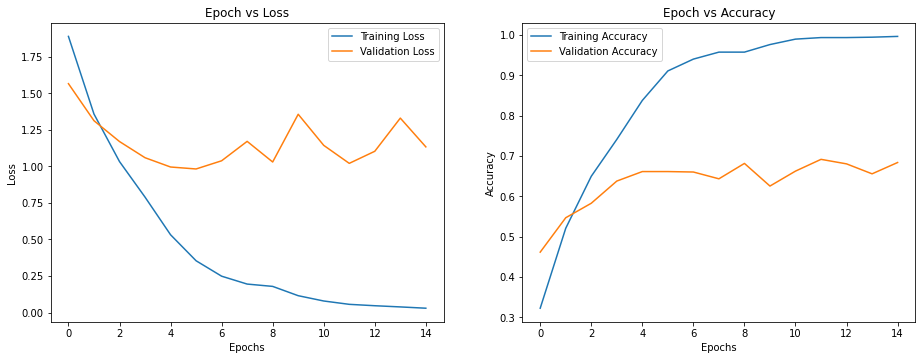

In [31]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

The Train accuracy= 0.1774891774891775 
 The Validation acc 0.2760942760942761
The Train loss= 2.2317793369293213 
 The Validation loss 2.0908964395523073


The Train accuracy= 0.30976430976430974 
 The Validation acc 0.34118967452300786
The Train loss= 1.980887770652771 
 The Validation loss 1.8923773129781087


The Train accuracy= 0.3641173641173641 
 The Validation acc 0.37485970819304154
The Train loss= 1.8273555040359497 
 The Validation loss 1.767537538210551


The Train accuracy= 0.405002405002405 
 The Validation acc 0.44332210998877664
The Train loss= 1.709387183189392 
 The Validation loss 1.6717406551043192


The Train accuracy= 0.43386243386243384 
 The Validation acc 0.4601571268237935
The Train loss= 1.6257803440093994 
 The Validation loss 1.6084537704785664


The Train accuracy= 0.4766714766714767 
 The Validation acc 0.4837261503928171
The Train loss= 1.5493749380111694 
 The Validation loss 1.5505264520645141


The Train accuracy= 0.506012506012506 
 The Validation ac

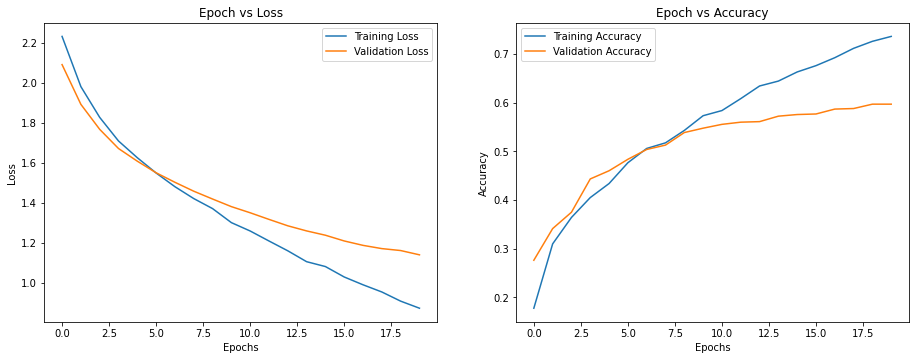

In [32]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.9)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 20 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# lets work with the same model but diff features

This SGD opt model

In [33]:
class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out


## first and third features

In [34]:
first_and_third_feat= np.concatenate( (first_feat , third_feat), axis=1).reshape(2970,1,129,108)

x_train , x_test , y_train , y_test = train_test_split( first_and_third_feat , labels , train_size=0.7, stratify=labels )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.20346320346320346 
 The Validation acc 0.35353535353535354
The Train loss= 2.1632730960845947 
 The Validation loss 1.8352708180745443


The Train accuracy= 0.37662337662337664 
 The Validation acc 0.45791245791245794
The Train loss= 1.6945933103561401 
 The Validation loss 1.525923224290212


The Train accuracy= 0.48484848484848486 
 The Validation acc 0.5129068462401796
The Train loss= 1.424481987953186 
 The Validation loss 1.3931995431582134


The Train accuracy= 0.5493025493025493 
 The Validation acc 0.55331088664422
The Train loss= 1.2717442512512207 
 The Validation loss 1.3040018697579703


The Train accuracy= 0.6065416065416065 
 The Validation acc 0.5914702581369248
The Train loss= 1.1297757625579834 
 The Validation loss 1.2256810088952383


The Train accuracy= 0.645983645983646 
 The Validation acc 0.5937149270482603
The Train loss= 1.019797682762146 
 The Validation loss 1.181922549009323


The Train accuracy= 0.684944684944685 
 The Validation acc 0

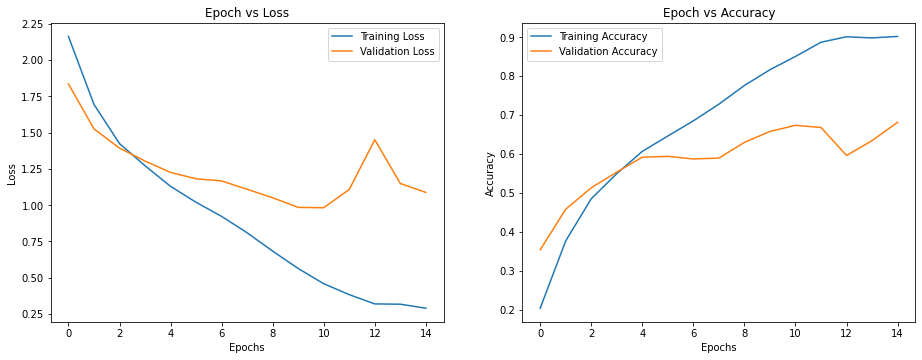

In [35]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

## first and fourth features

In [36]:
forth_feat.shape

(2970, 12, 108)

The Train accuracy= 0.32996632996632996 
 The Validation acc 0.4444444444444444
The Train loss= 1.8793734312057495 
 The Validation loss 1.4915289044380189


The Train accuracy= 0.568061568061568 
 The Validation acc 0.5791245791245792
The Train loss= 1.2751035690307617 
 The Validation loss 1.2453776001930237


The Train accuracy= 0.6738816738816739 
 The Validation acc 0.6127946127946128
The Train loss= 0.972487211227417 
 The Validation loss 1.1481589595476787


The Train accuracy= 0.7869167869167869 
 The Validation acc 0.632996632996633
The Train loss= 0.7014418244361877 
 The Validation loss 1.0987009227275848


The Train accuracy= 0.8638768638768639 
 The Validation acc 0.6049382716049383
The Train loss= 0.48345649242401123 
 The Validation loss 1.2018435577551523


The Train accuracy= 0.9312169312169312 
 The Validation acc 0.6341189674523008
The Train loss= 0.31167060136795044 
 The Validation loss 1.2215301851431528


The Train accuracy= 0.9446849446849447 
 The Validation ac

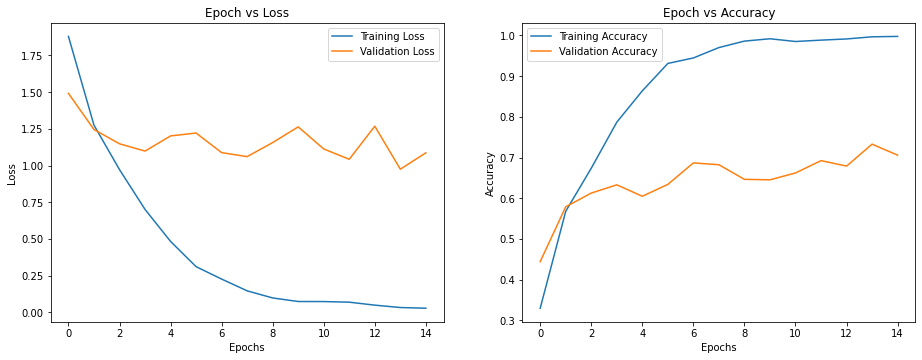

In [37]:
class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 32, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 32 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

first_and_forth_feat= np.concatenate( (first_feat , forth_feat), axis=1).reshape( 2970,1,140, 108)

x_train , x_test , y_train , y_test = train_test_split( first_and_forth_feat , labels , train_size=0.7, stratify=labels )

transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)
net = music_CNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001 )
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

The Train accuracy= 0.19480519480519481 
 The Validation acc 0.30303030303030304
The Train loss= 2.1808249950408936 
 The Validation loss 1.9059792041778565


The Train accuracy= 0.38672438672438675 
 The Validation acc 0.4511784511784512
The Train loss= 1.6968870162963867 
 The Validation loss 1.5427996953328451


The Train accuracy= 0.4973544973544973 
 The Validation acc 0.5375982042648709
The Train loss= 1.4284347295761108 
 The Validation loss 1.373193750778834


The Train accuracy= 0.582010582010582 
 The Validation acc 0.5140291806958474
The Train loss= 1.2187901735305786 
 The Validation loss 1.2974281410376232


The Train accuracy= 0.6161616161616161 
 The Validation acc 0.5499438832772167
The Train loss= 1.0849660634994507 
 The Validation loss 1.3175015966097514


The Train accuracy= 0.6873496873496874 
 The Validation acc 0.6184062850729517
The Train loss= 0.932709813117981 
 The Validation loss 1.143973163763682


The Train accuracy= 0.7272727272727273 
 The Validation acc

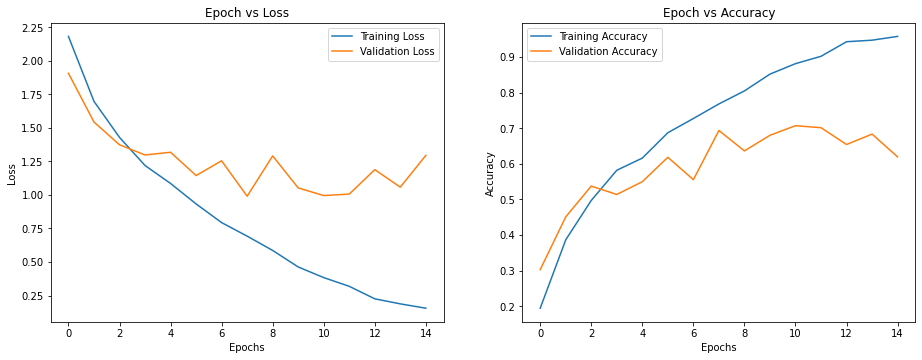

In [38]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

## first, sec and third

In [39]:
three_features= np.concatenate( (first_feat , sec_feat  ,third_feat), axis=1).reshape( 2970,1,130, 108)

x_train , x_test , y_train , y_test = train_test_split( three_features , labels , train_size=0.7, stratify=labels )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.18037518037518038 
 The Validation acc 0.29854096520763185
The Train loss= 2.1810715198516846 
 The Validation loss 1.9366068283716837


The Train accuracy= 0.33525733525733525 
 The Validation acc 0.3950617283950617
The Train loss= 1.7853931188583374 
 The Validation loss 1.6444451769193014


The Train accuracy= 0.4660894660894661 
 The Validation acc 0.49719416386083054
The Train loss= 1.4881678819656372 
 The Validation loss 1.4147061347961425


The Train accuracy= 0.5228475228475229 
 The Validation acc 0.48035914702581367
The Train loss= 1.3467907905578613 
 The Validation loss 1.4370261232058208


The Train accuracy= 0.5747955747955747 
 The Validation acc 0.5151515151515151
The Train loss= 1.2398173809051514 
 The Validation loss 1.3879677335421243


The Train accuracy= 0.6151996151996152 
 The Validation acc 0.5331088664421998
The Train loss= 1.1246484518051147 
 The Validation loss 1.317481948932012


The Train accuracy= 0.645983645983646 
 The Validation

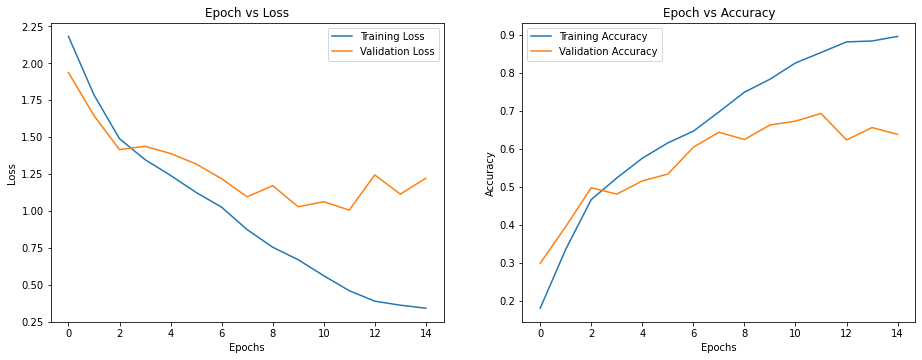

In [40]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

### three features with gausian

In [41]:
three_features= np.concatenate( (first_feat , sec_feat  ,third_feat), axis=1).reshape( 2970,1,130, 108)

x_train , x_test , y_train , y_test = train_test_split( three_features , labels , train_size=0.7, stratify=labels )

transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.21885521885521886 
 The Validation acc 0.3344556677890011
The Train loss= 2.1480295658111572 
 The Validation loss 1.8792590697606404


The Train accuracy= 0.35738335738335736 
 The Validation acc 0.4567901234567901
The Train loss= 1.7572616338729858 
 The Validation loss 1.5837310194969176


The Train accuracy= 0.45262145262145265 
 The Validation acc 0.47474747474747475
The Train loss= 1.5147500038146973 
 The Validation loss 1.5341439644495647


The Train accuracy= 0.4963924963924964 
 The Validation acc 0.49719416386083054
The Train loss= 1.4088892936706543 
 The Validation loss 1.4577026883761088


The Train accuracy= 0.544973544973545 
 The Validation acc 0.5634118967452301
The Train loss= 1.2658525705337524 
 The Validation loss 1.3083886504173279


The Train accuracy= 0.6118326118326118 
 The Validation acc 0.5735129068462402
The Train loss= 1.1297457218170166 
 The Validation loss 1.257360581556956


The Train accuracy= 0.683020683020683 
 The Validation 

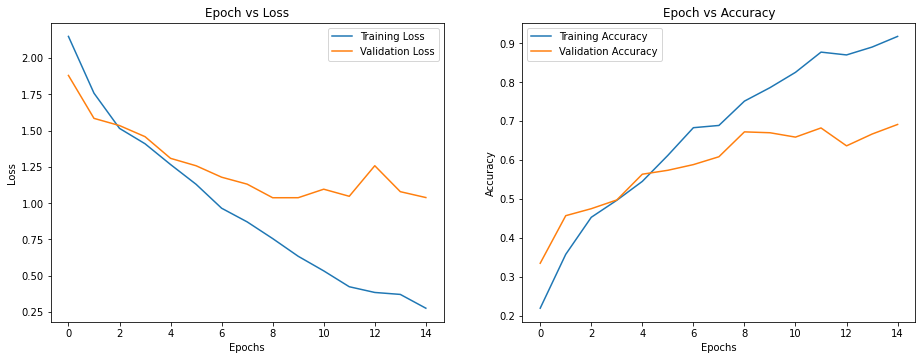

In [42]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 15 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

## using all the features but with no noise

In [43]:
all_features= np.concatenate( (first_feat , sec_feat  ,third_feat, forth_feat), axis=1).reshape( 2970,1,142, 108)

x_train , x_test , y_train , y_test = train_test_split( all_features , labels , train_size=0.7, stratify=labels )

#transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train) )
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)

The Train accuracy= 0.15728715728715728 
 The Validation acc 0.2547699214365881
The Train loss= 2.2577967643737793 
 The Validation loss 2.1591154893239337


The Train accuracy= 0.29244829244829246 
 The Validation acc 0.3265993265993266
The Train loss= 1.990911602973938 
 The Validation loss 1.8594825863838196


The Train accuracy= 0.3424723424723425 
 The Validation acc 0.3479236812570146
The Train loss= 1.7714935541152954 
 The Validation loss 1.7532551646232606


The Train accuracy= 0.40404040404040403 
 The Validation acc 0.4163860830527497
The Train loss= 1.6248451471328735 
 The Validation loss 1.5348210175832113


The Train accuracy= 0.43482443482443484 
 The Validation acc 0.4725028058361392
The Train loss= 1.5121098756790161 
 The Validation loss 1.4455550551414489


The Train accuracy= 0.48484848484848486 
 The Validation acc 0.3569023569023569
The Train loss= 1.4378706216812134 
 The Validation loss 1.8060530503590901


The Train accuracy= 0.5252525252525253 
 The Validatio

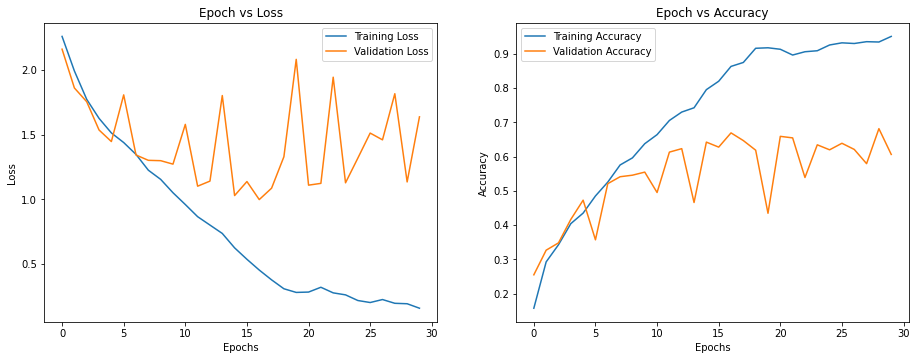

In [44]:
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001 , momentum=0.99)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 30 , optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# THE BEST MODEL : using only first and forth features

Epoch: 1
The Train accuracy= 0.21422558922558924 
 The Validation acc 0.367003367003367
The Train loss= 2.1728947162628174 
 The Validation loss 1.7501022040843963


Epoch: 2
The Train accuracy= 0.3930976430976431 
 The Validation acc 0.49663299663299665
The Train loss= 1.6788610219955444 
 The Validation loss 1.3977862179279328


Epoch: 3
The Train accuracy= 0.47095959595959597 
 The Validation acc 0.5387205387205387
The Train loss= 1.4842064380645752 
 The Validation loss 1.3441503286361693


Epoch: 4
The Train accuracy= 0.5151515151515151 
 The Validation acc 0.5016835016835017
The Train loss= 1.3516250848770142 
 The Validation loss 1.4574017882347108


Epoch: 5
The Train accuracy= 0.5521885521885522 
 The Validation acc 0.5841750841750841
The Train loss= 1.2514238357543945 
 The Validation loss 1.1751571476459504


Epoch: 6
The Train accuracy= 0.5845959595959596 
 The Validation acc 0.6380471380471381
The Train loss= 1.1443548202514648 
 The Validation loss 1.0340128749608994


Ep

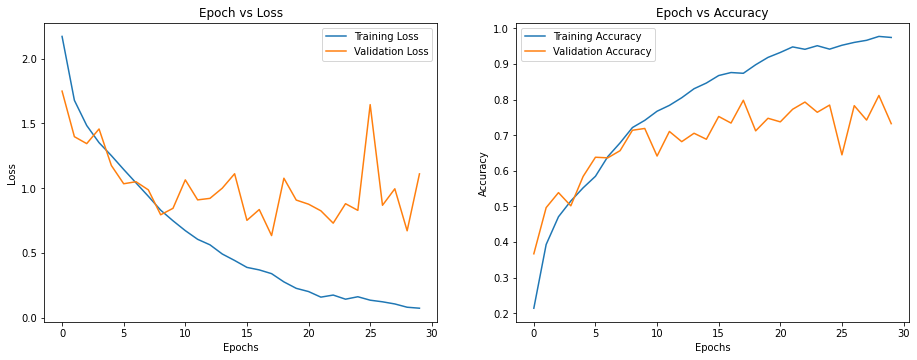

In [48]:
class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 64, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(0.3),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 256 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(0.4),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 512 ) ,
            nn.MaxPool2d(kernel_size=2),


        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=512),
            nn.Dropout(0.4),
            nn.Linear(in_features=512, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

def train(model, device, train_loader, validation_loader, epochs , optimizer):
  criterion =  nn.CrossEntropyLoss()
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device, dtype=torch.float ), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)
      print(f'Epoch: {epoch+1}')
      print(f'The Train accuracy= {train_acc[epoch]} \n The Validation acc {validation_acc[epoch]}') 
      print(f'The Train loss= {train_loss[epoch]} \n The Validation loss {validation_loss[epoch]}')  
      print('\n')
  return train_loss, train_acc, validation_loss, validation_acc

first_and_forth_feat= np.concatenate( (first_feat , forth_feat), axis=1).reshape( 2970,1,140, 108)

x_train , x_test , y_train , y_test = train_test_split( first_and_forth_feat , labels , train_size=0.8, stratify=labels )

transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train), transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)
net = music_CNN().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.99 )
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, test_loader, 30, optimizer)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)